In [1]:
%matplotlib inline


Group analysis of resting-state fMRI with ICA: CanICA
=====================================================

An example applying CanICA to resting-state data. This example applies it
to 30 subjects of the ADHD200 datasets. Then it plots a map with all the
components together and an axial cut for each of the components separately.

CanICA is an ICA method for group-level analysis of fMRI data. Compared
to other strategies, it brings a well-controlled group model, as well as a
thresholding algorithm controlling for specificity and sensitivity with
an explicit model of the signal. The reference papers are:

    * G. Varoquaux et al. "A group model for stable multi-subject ICA on
      fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299

    * G. Varoquaux et al. "ICA-based sparse features recovery from fMRI
      datasets", IEEE ISBI 2010, p. 1177

Pre-prints for both papers are available on hal
(http://hal.archives-ouvertes.fr)

<div class="alert alert-info"><h4>Note</h4><p>The use of the attribute `components_img_` from decomposition
    estimators is implemented from version 0.4.1.
    For older versions, unmask the deprecated attribute `components_`
    to get the components image using attribute `masker_` embedded in
    estimator.
    See the `section Inverse transform: unmasking data <unmasking_step>`.</p></div>



1 load the ADHD200 data
-------------------------------



In [2]:
from nilearn import datasets
#dir='/raid/nilearn_data'
adhd_dataset = datasets.fetch_adhd(n_subjects=30,data_dir='/home/share/TmpData/Qinglin/nilearn_data/')
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

First functional nifti image (4D) is at: /home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


/home/uga_qinglin/Documents/nilearn-deep/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


2 apply CanICA on the data
---------------------------------



In [3]:
from sklearn.decomposition import dict_learning_online
from nilearn.decomposition import DictLearning, CanICA
dict_learning = DictLearning(n_components=30,
                             memory="nilearn_cache", memory_level=2,
                             verbose=1,
                             random_state=0,
                             n_epochs=1)
data=dict_learning.prepare_data(func_filenames)

dict_learning._raw_fit2(data)
components_img=dict_learning.components_
#_, diction=dict_learning_online(data,n_components=30,alpha=1,n_iter=100)
#components_img=diction

[MultiNiftiMasker.fit] Loading data from [/home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz, /home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.g
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[DictLearning] Loading data
/home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
/home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010064/0010064_rest_tshift_RPI_voreg_mni.nii.gz
/home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010128/0010128_rest_tshift_RPI_voreg_mni.nii.gz
/home/share/TmpData/Qinglin/nilearn_data/adhd/data/0021019/0021019_rest_tshift_RPI_voreg_mni.nii.gz
/home/share/TmpData/Qinglin/nilearn_data/adhd/data/0023008/0023008_rest_tshift_RPI_voreg_mni.nii.gz
/home/share/TmpData/Qinglin/nilearn_data/adhd/data/0023012/0023012_rest_tshift_RPI_voreg_mni.nii.gz
/home/share/TmpData/Qinglin/nilearn_data/adhd/d

3 plot each ICA component separately
-----------------------------------------------------------



In [4]:
components_img.shape

(30, 64246)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


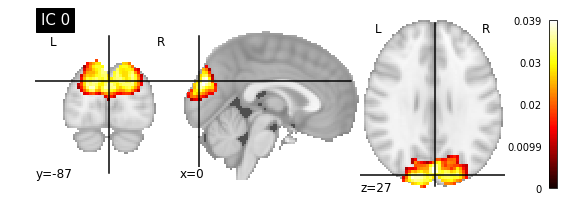

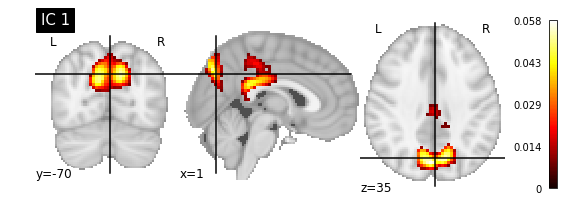

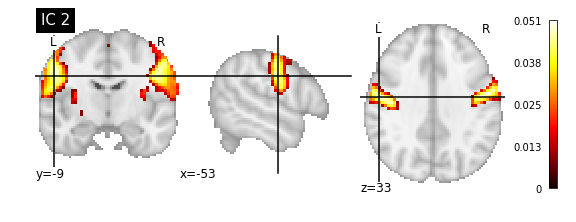

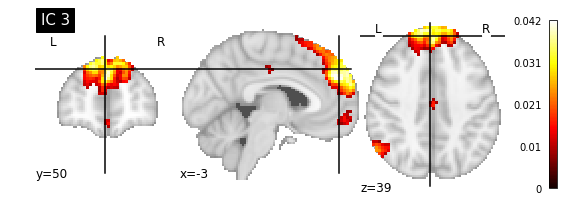

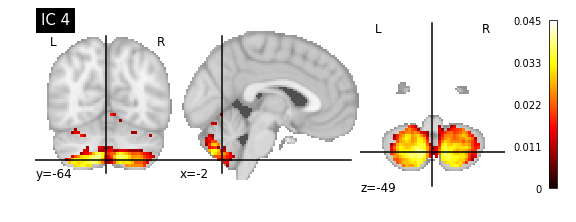

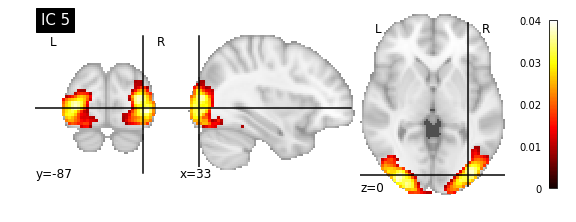

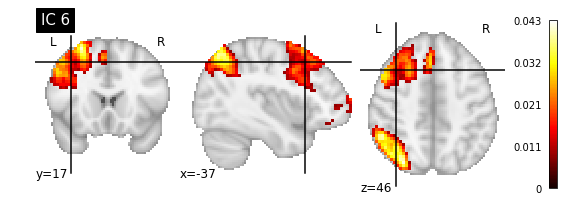

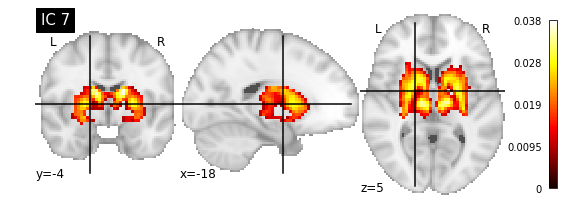

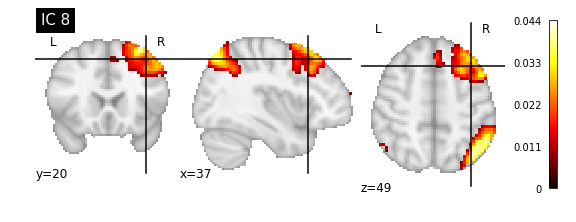

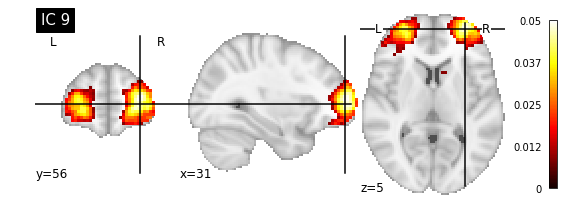

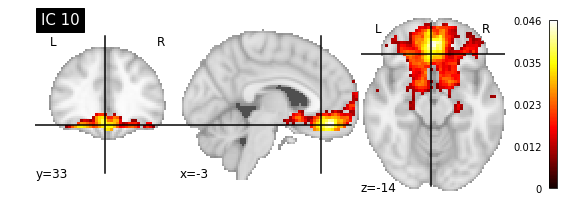

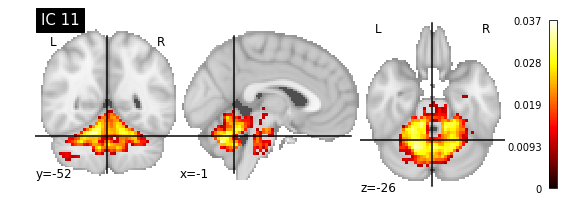

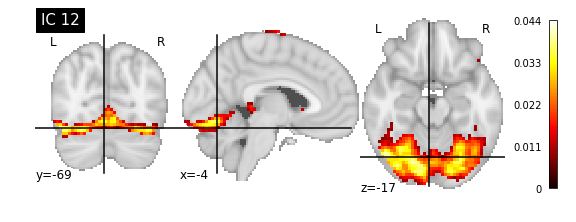

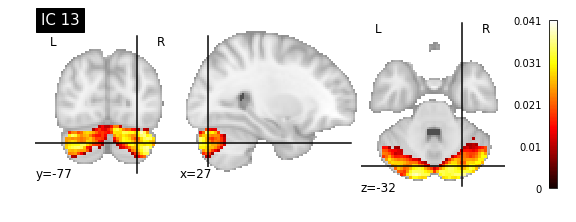

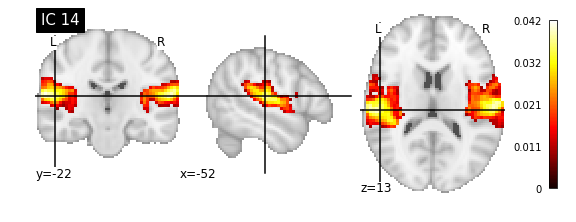

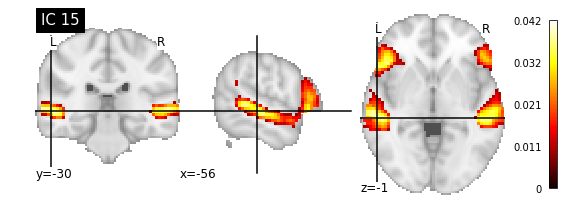

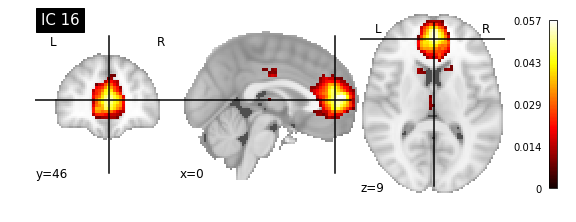

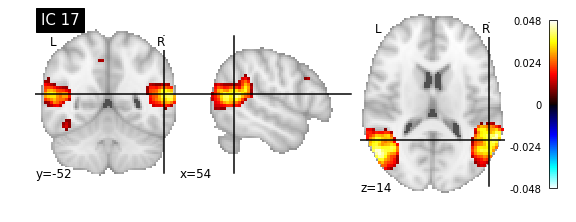

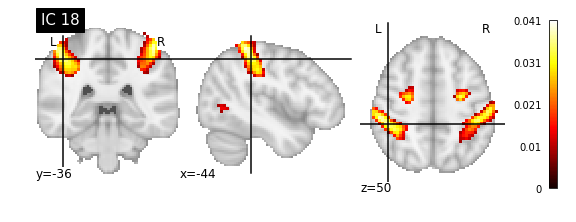

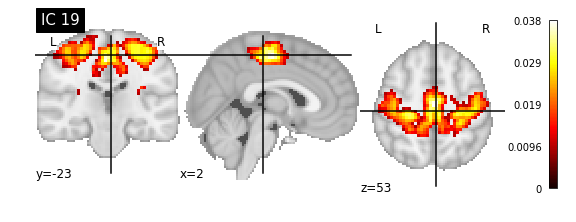

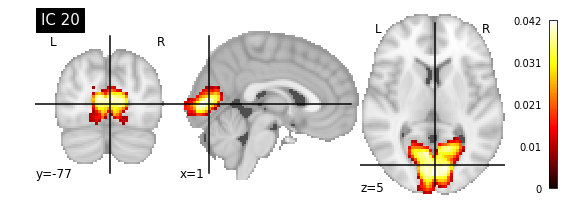

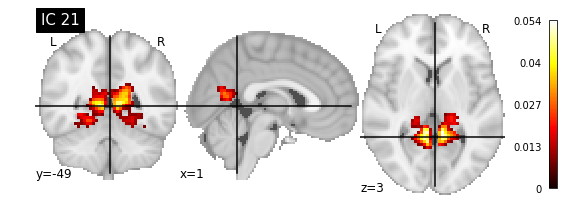

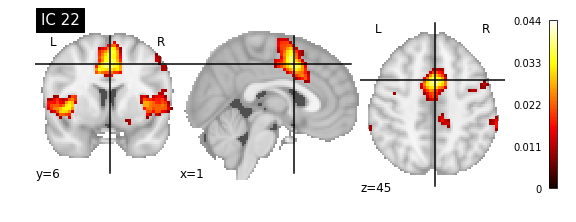

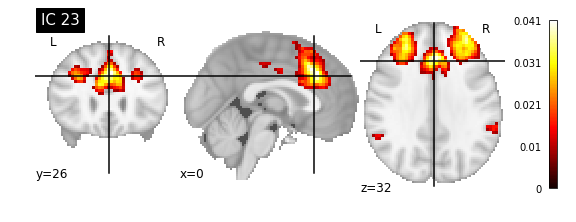

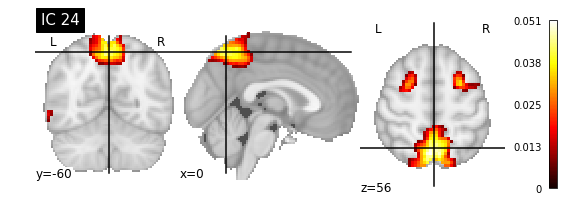

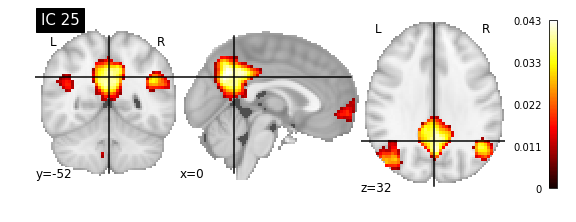

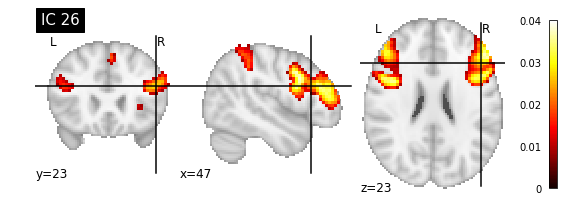

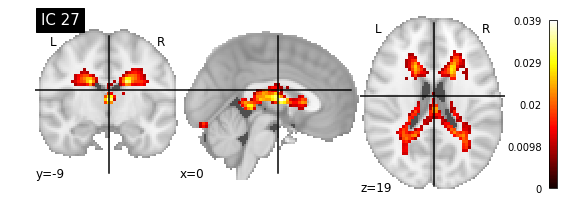

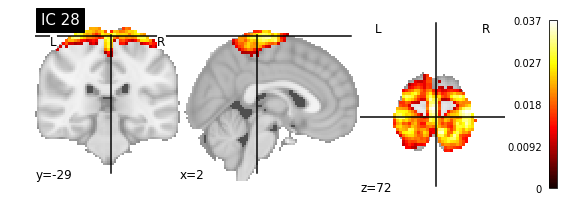

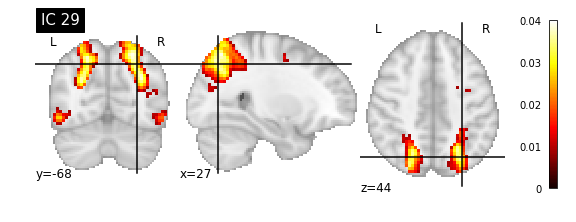

In [5]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=dict_learning.masker_.mask_img_, standardize=True)
masker.fit()



components_img = dict_learning.thresholding(components_img)
components_img = masker.inverse_transform(components_img)

from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()

1 Extract regions from networks
------------------------------



/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


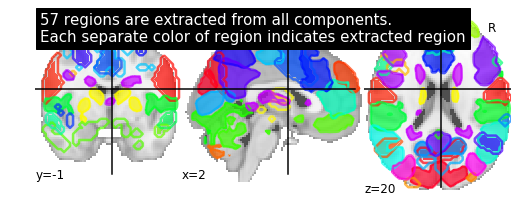

In [6]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=5000)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

from nilearn.plotting import plot_prob_atlas
# Visualization of region extraction results
title = ('%d regions are extracted from %s components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 'all'))
plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

2 Region signals extraction
------------------------------



In [7]:
# First we need to do subjects timeseries signals extraction and then estimating
# correlation matrices on those signals.
# To extract timeseries signals, we call transform() from RegionExtractor object
# onto each subject functional data stored in func_filenames.
# To estimate correlation matrices we import connectome utilities from nilearn
from nilearn.connectome import ConnectivityMeasure
confounds = adhd_dataset.confounds
phenotypic = adhd_dataset.phenotypic
adhd_time_series = []
all_time_series = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
# Initializing ConnectivityMeasure object with kind='correlation'
correlation_measure = ConnectivityMeasure(kind='correlation')
for filename, confound, phenotypic in zip(func_filenames, confounds,phenotypic):
    time_series = extractor.transform(filename, confounds=confound)   
    all_time_series.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_time_series.append(time_series)
    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)        
print('Data has {0} ADHD subjects.'.format(len(adhd_time_series)))        




KeyboardInterrupt: 

3  Correlation coefficients
------------------------------



In [ ]:
# Matrix plotting from Nilearn: nilearn.plotting.plot_matrix
import numpy as np
import matplotlib.pylab as plt

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

In [ ]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = correlation_measure.fit_transform(adhd_time_series)
        
from nilearn import plotting
plot_matrices(correlation_matrices[:4], 'correlation')


4 group-sparse precision matrices
------------------------------------------



In [ ]:
from nilearn.connectome import GroupSparseCovarianceCV
gsc = GroupSparseCovarianceCV(verbose=2)
gsc.fit(adhd_time_series)

In [ ]:
def plot_matrices_2(cov, prec, title, labels=None):
    """Plot covariance and precision matrices, for a given processing. """

    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plotting.plot_matrix(cov, cmap=plotting.cm.bwr,
                         vmin=-1, vmax=1, title="%s / covariance" % title,
                         labels=labels)
    # Display precision matrix
    plotting.plot_matrix(prec, cmap=plotting.cm.bwr,
                         vmin=-span, vmax=span, title="%s / precision" % title,
                         labels=labels)

title = "GroupSparseCovariance"
plot_matrices_2(gsc.covariances_[..., 0],
              gsc.precisions_[..., 0], title)

from nilearn.plotting import find_cuts
regions_img = regions_extracted_img
coords_connectome = find_cuts.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(-gsc.precisions_[..., 0],
                         coords_connectome, edge_threshold='90%',
                         title=title,
                         display_mode="lzr",
                         edge_vmax=.5, edge_vmin=-.5)

plotting.show()


In [ ]:
from nilearn.plotting import html_connectome
view = html_connectome.view_connectome(-gsc.precisions_[..., 0], coords_connectome, threshold='95%')
view.open_in_browser()
view

5 classification
----------------------------



In [ ]:
connectivity_biomarkers = {}

conn_measure = ConnectivityMeasure(kind='correlation', vectorize=True)
connectivity_biomarkers = conn_measure.fit_transform(all_time_series)

# For each kind, all individual coefficients are stacked in a unique 2D matrix.
print('{0} correlation biomarkers for each subject.'.format(
    connectivity_biomarkers.shape[1]))



In [ ]:
from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(site_names, adhd_labels)]
cv = StratifiedKFold(n_splits=5)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

from sklearn.model_selection import cross_val_score
mean_scores = []

for name, clf in zip(names, classifiers):
    cv_scores = cross_val_score(clf,
                                connectivity_biomarkers,
                                y=adhd_labels,
                                cv=cv,
                                groups=adhd_labels,
                                scoring='accuracy',
                                )
    mean_scores.append(cv_scores.mean())


In [ ]:
from nilearn.plotting import show

plt.figure(figsize=(6, 4))
positions = np.arange(len(names)) * .1 + .1
plt.barh(positions, mean_scores, align='center', height=.05)
yticks = [name.replace(' ', '\n') for name in names]
plt.yticks(positions, yticks)
plt.xlabel('Classification accuracy')
plt.grid(True)
plt.tight_layout()

show()


3D map
----------------------------



In [ ]:
from nilearn import plotting, datasets     
view = plotting.view_img_on_surf(cur_img, threshold='90%', surf_mesh='fsaverage')   
view.open_in_browser() 
view